## Import libraries 📚

In [8]:
import numpy as np 
import pandas as pd 
import polars as pl
import os
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostRegressor, Pool
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor


In [6]:
%%time

train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
# Original = pd.read_csv('/kaggle/input/used-car-price-prediction-dataset/used_cars.csv')


# Original[['milage', 'price']] = Original[['milage', 'price']].map(
#     lambda x: int(''.join(re.findall(r'\d+', x))))

# train = pd.concat([train, Original], ignore_index=True)

CPU times: user 620 ms, sys: 50.8 ms, total: 670 ms
Wall time: 670 ms


In [10]:
train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900


## Feature Types🧩

In [7]:
categorical_features = train.select_dtypes(include='object').columns.tolist()

numerical_features = train.select_dtypes(exclude='object').columns.tolist()

for feature in ['price', 'id']:
    if feature in numerical_features:
        numerical_features.remove(feature)
df_numerical = pd.DataFrame({'Numerical Variables': numerical_features})
df_categorical = pd.DataFrame({'Categorical Variables': categorical_features})

## Analyzing Vehicle Pricing Trends 💲

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


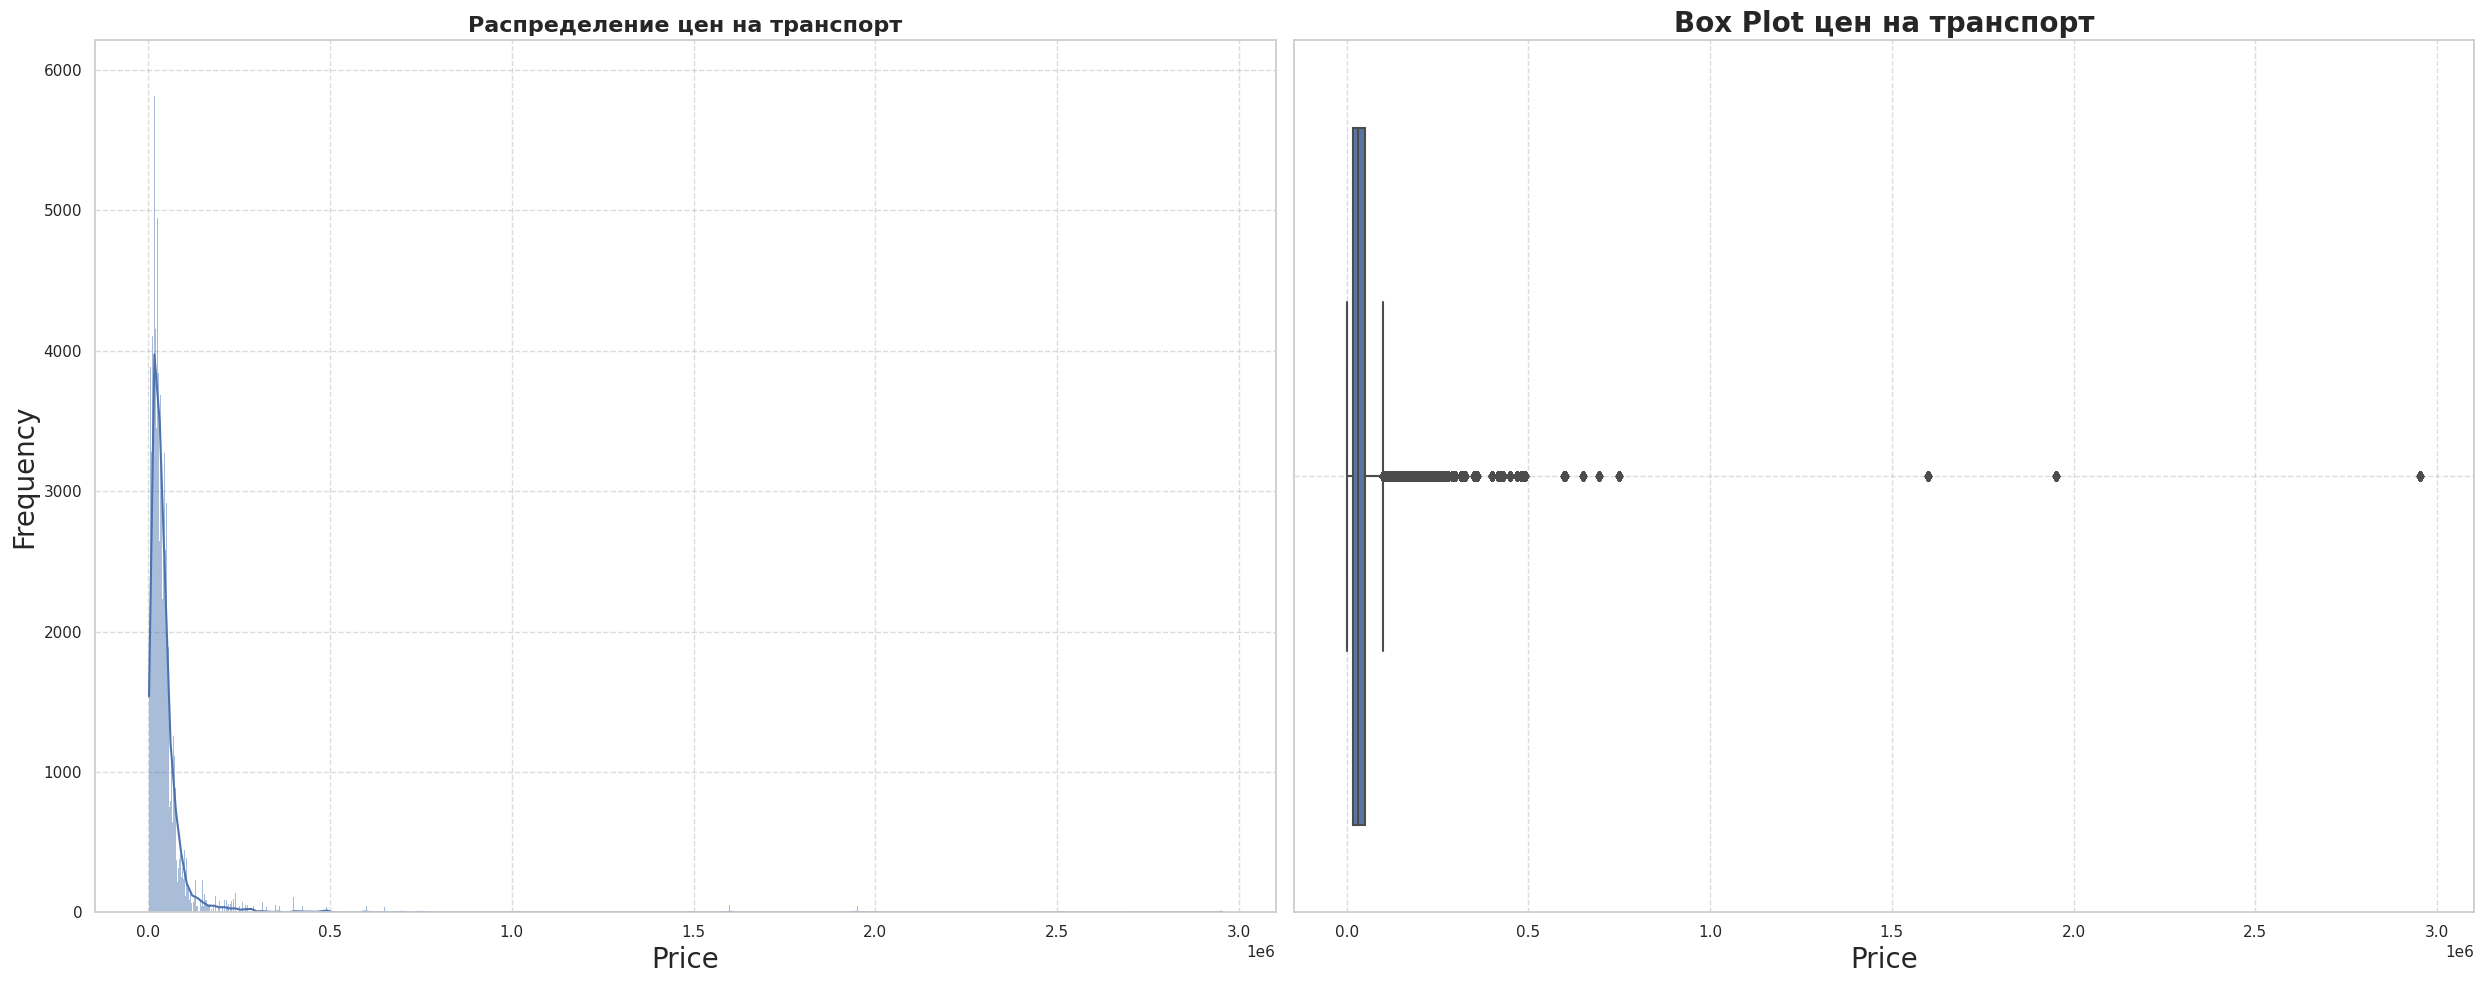

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

sns.set(style="whitegrid")

sns.histplot(train['price'], kde=True, ax=ax[0])
ax[0].set_title('Распределение цен на транспорт', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Price', fontsize=20, )
ax[0].set_ylabel('Frequency', fontsize=20, )
ax[0].patch.set_alpha(0.1)
ax[0].grid(True, linestyle='--', alpha=0.7)

sns.boxplot(x=train['price'], ax=ax[1])
ax[1].set_title('Box Plot цен на транспорт', fontsize=20, fontweight='bold')
ax[1].set_xlabel('Price', fontsize=20)
ax[1].patch.set_alpha(0.1) 
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Fuel Type Distribution Analysis ⛽

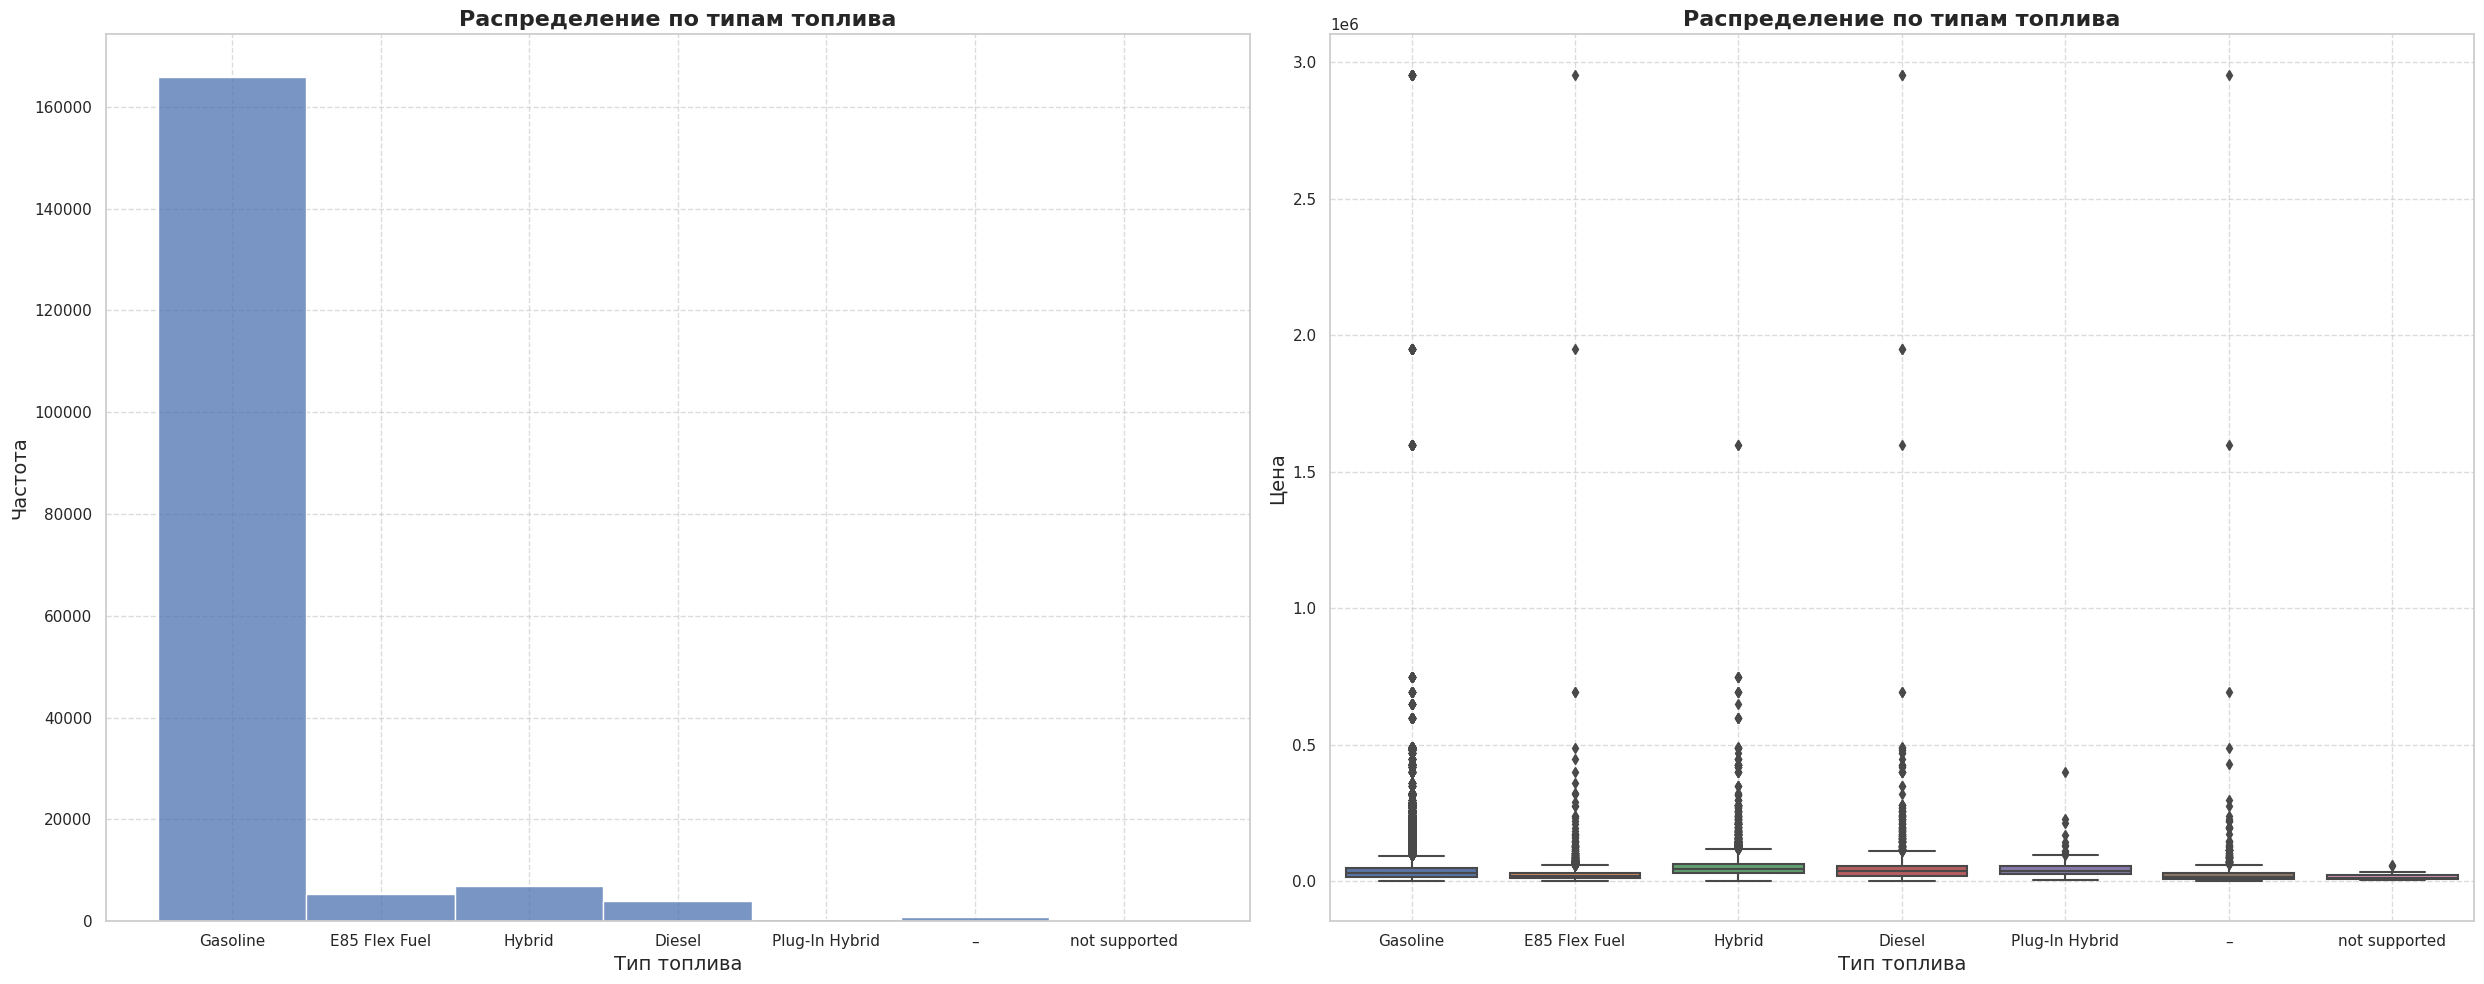

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))  

sns.set(style="whitegrid")

sns.histplot(train['fuel_type'], kde=False, ax=ax[0])
ax[0].set_title('Распределение по типам топлива', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Тип топлива', fontsize=14)
ax[0].set_ylabel('Частота', fontsize=14,)
ax[0].patch.set_alpha(0.1) 
ax[0].grid(True, linestyle='--', alpha=0.7,) 

sns.boxplot(x='fuel_type', y='price', data=train, ax=ax[1])
ax[1].set_title('Распределение по типам топлива', fontsize=16, fontweight='bold', )
ax[1].set_xlabel('Тип топлива', fontsize=14,)
ax[1].set_ylabel('Цена', fontsize=14, )
ax[1].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[1].grid(True, linestyle='--', alpha=0.7, )  # Orange grid lines

# Adjust layout
plt.tight_layout()
plt.show()

## Price Analysis: Model Year and Mileage Insights 📈🚘

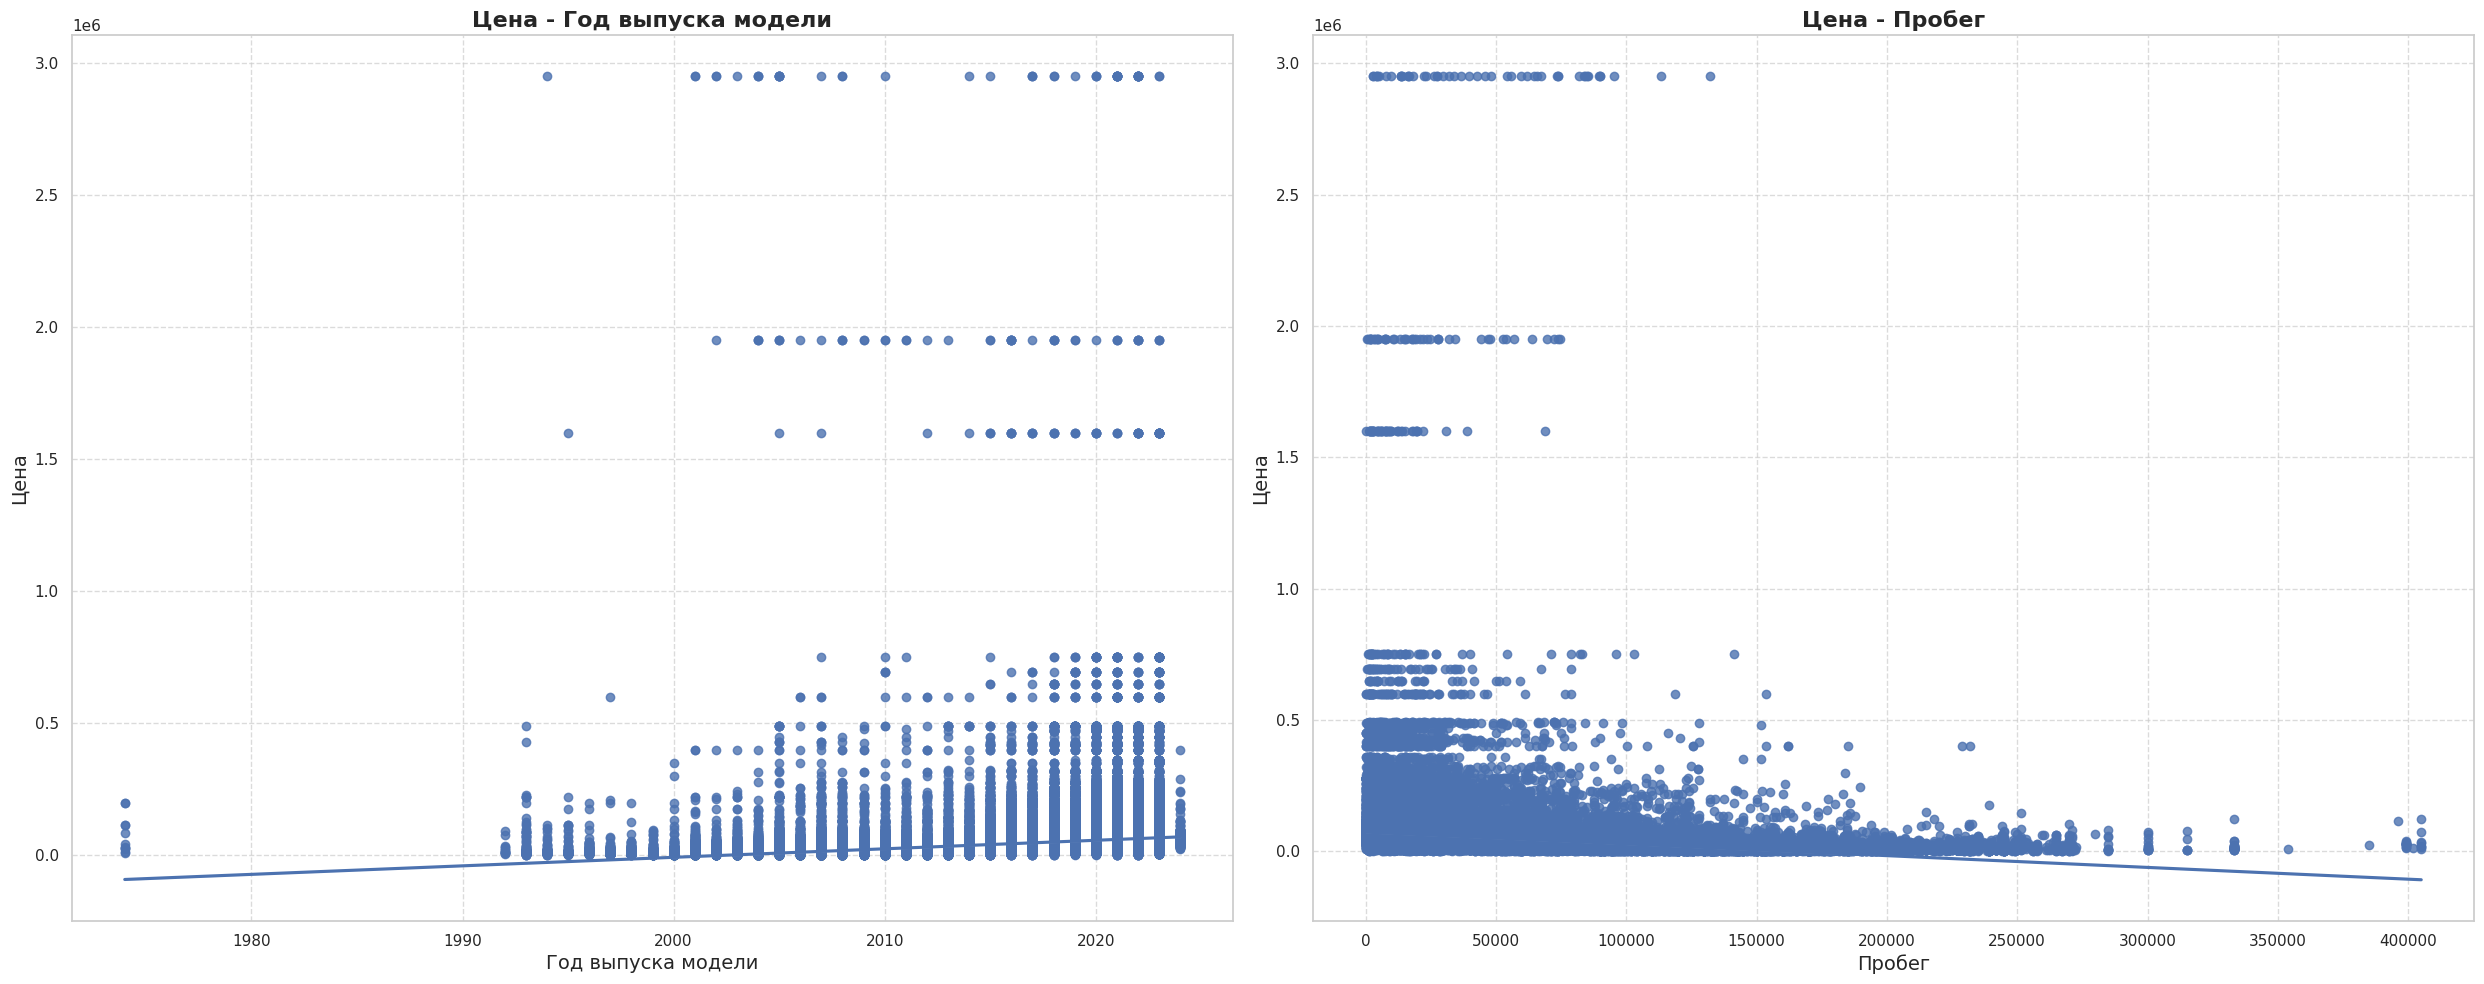

In [14]:
# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25, 10))  

# Set a general aesthetic style for the plots
sns.set(style="whitegrid")

# Scatter Plot with Regression Line for Price vs Model Year
sns.regplot(x='model_year', y='price', data=train, ax=ax[0])
ax[0].set_title('Цена - Год выпуска модели', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Год выпуска модели', fontsize=14)
ax[0].set_ylabel('Цена', fontsize=14)
ax[0].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[0].grid(True, linestyle='--', alpha=0.7)  # Orange grid lines

# Scatter Plot with Regression Line for Price vs Mileage
sns.regplot(x='milage', y='price', data=train, ax=ax[1])
ax[1].set_title('Цена - Пробег', fontsize=16, fontweight='bold',)
ax[1].set_xlabel('Пробег', fontsize=14,)
ax[1].set_ylabel('Цена', fontsize=14, )
ax[1].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[1].grid(True, linestyle='--', alpha=0.7,)  # Orange grid lines

# Adjust layout
plt.tight_layout()
plt.show()

## Accident History and Its Impact on Car Prices 🚗💥💵

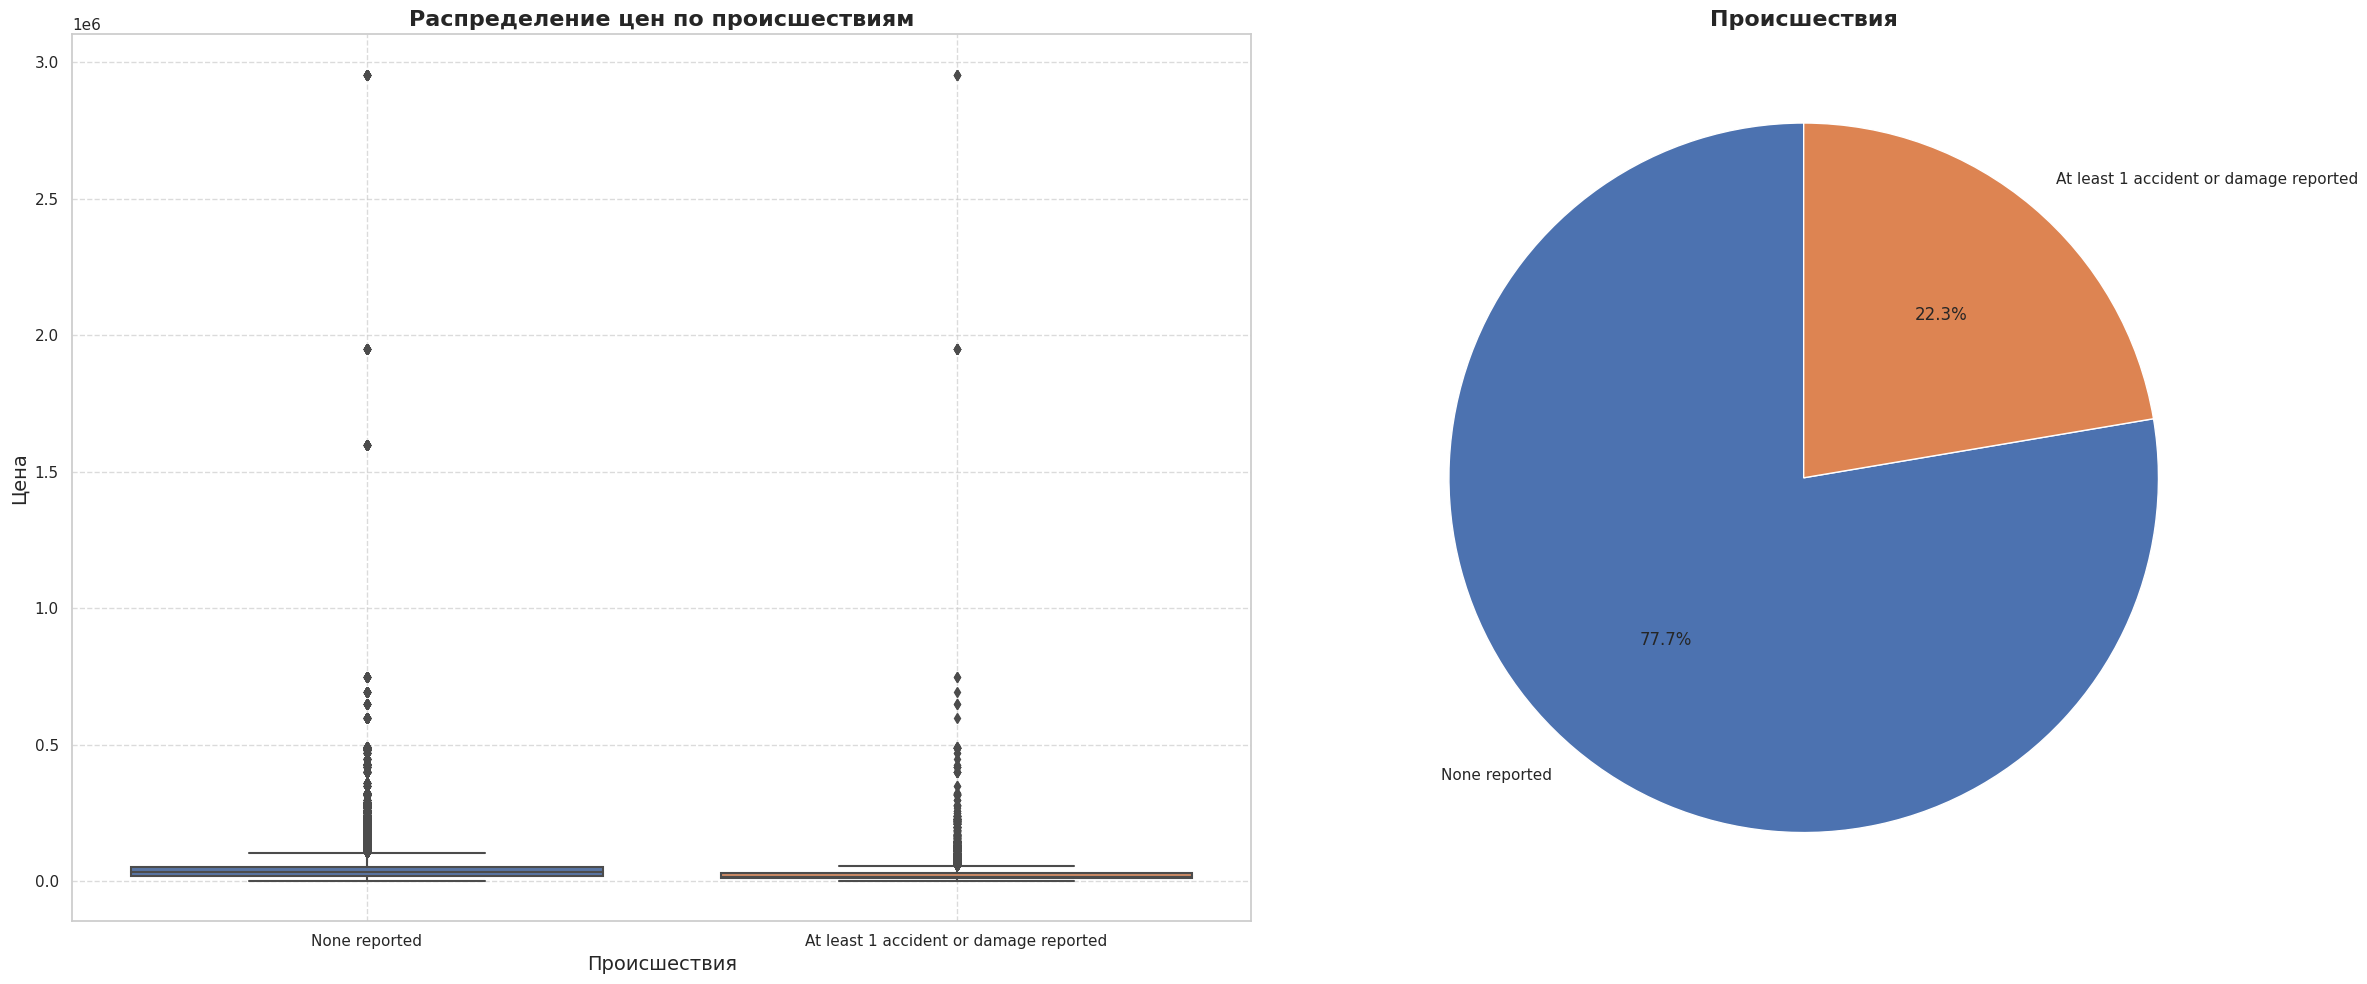

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(25, 10)) 
sns.set(style="whitegrid")

sns.boxplot(x='accident', y='price', data=train, ax=ax[0])
ax[0].set_title('Распределение цен по происшествиям', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Происшествия', fontsize=14)
ax[0].set_ylabel('Цена', fontsize=14)
ax[0].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[0].grid(True, linestyle='--', alpha=0.7)  # Orange grid lines

# Donut Chart for Accident History Proportion
accident_counts = train['accident'].value_counts()
ax[1].pie(accident_counts, labels=accident_counts.index, autopct='%1.1f%%', startangle=90,)
centre_circle = plt.Circle((0,0),0.70,)
ax[1].set_title('Происшествия', fontsize=16, fontweight='bold',)

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing Price Variations Across Brands 🏷️📉

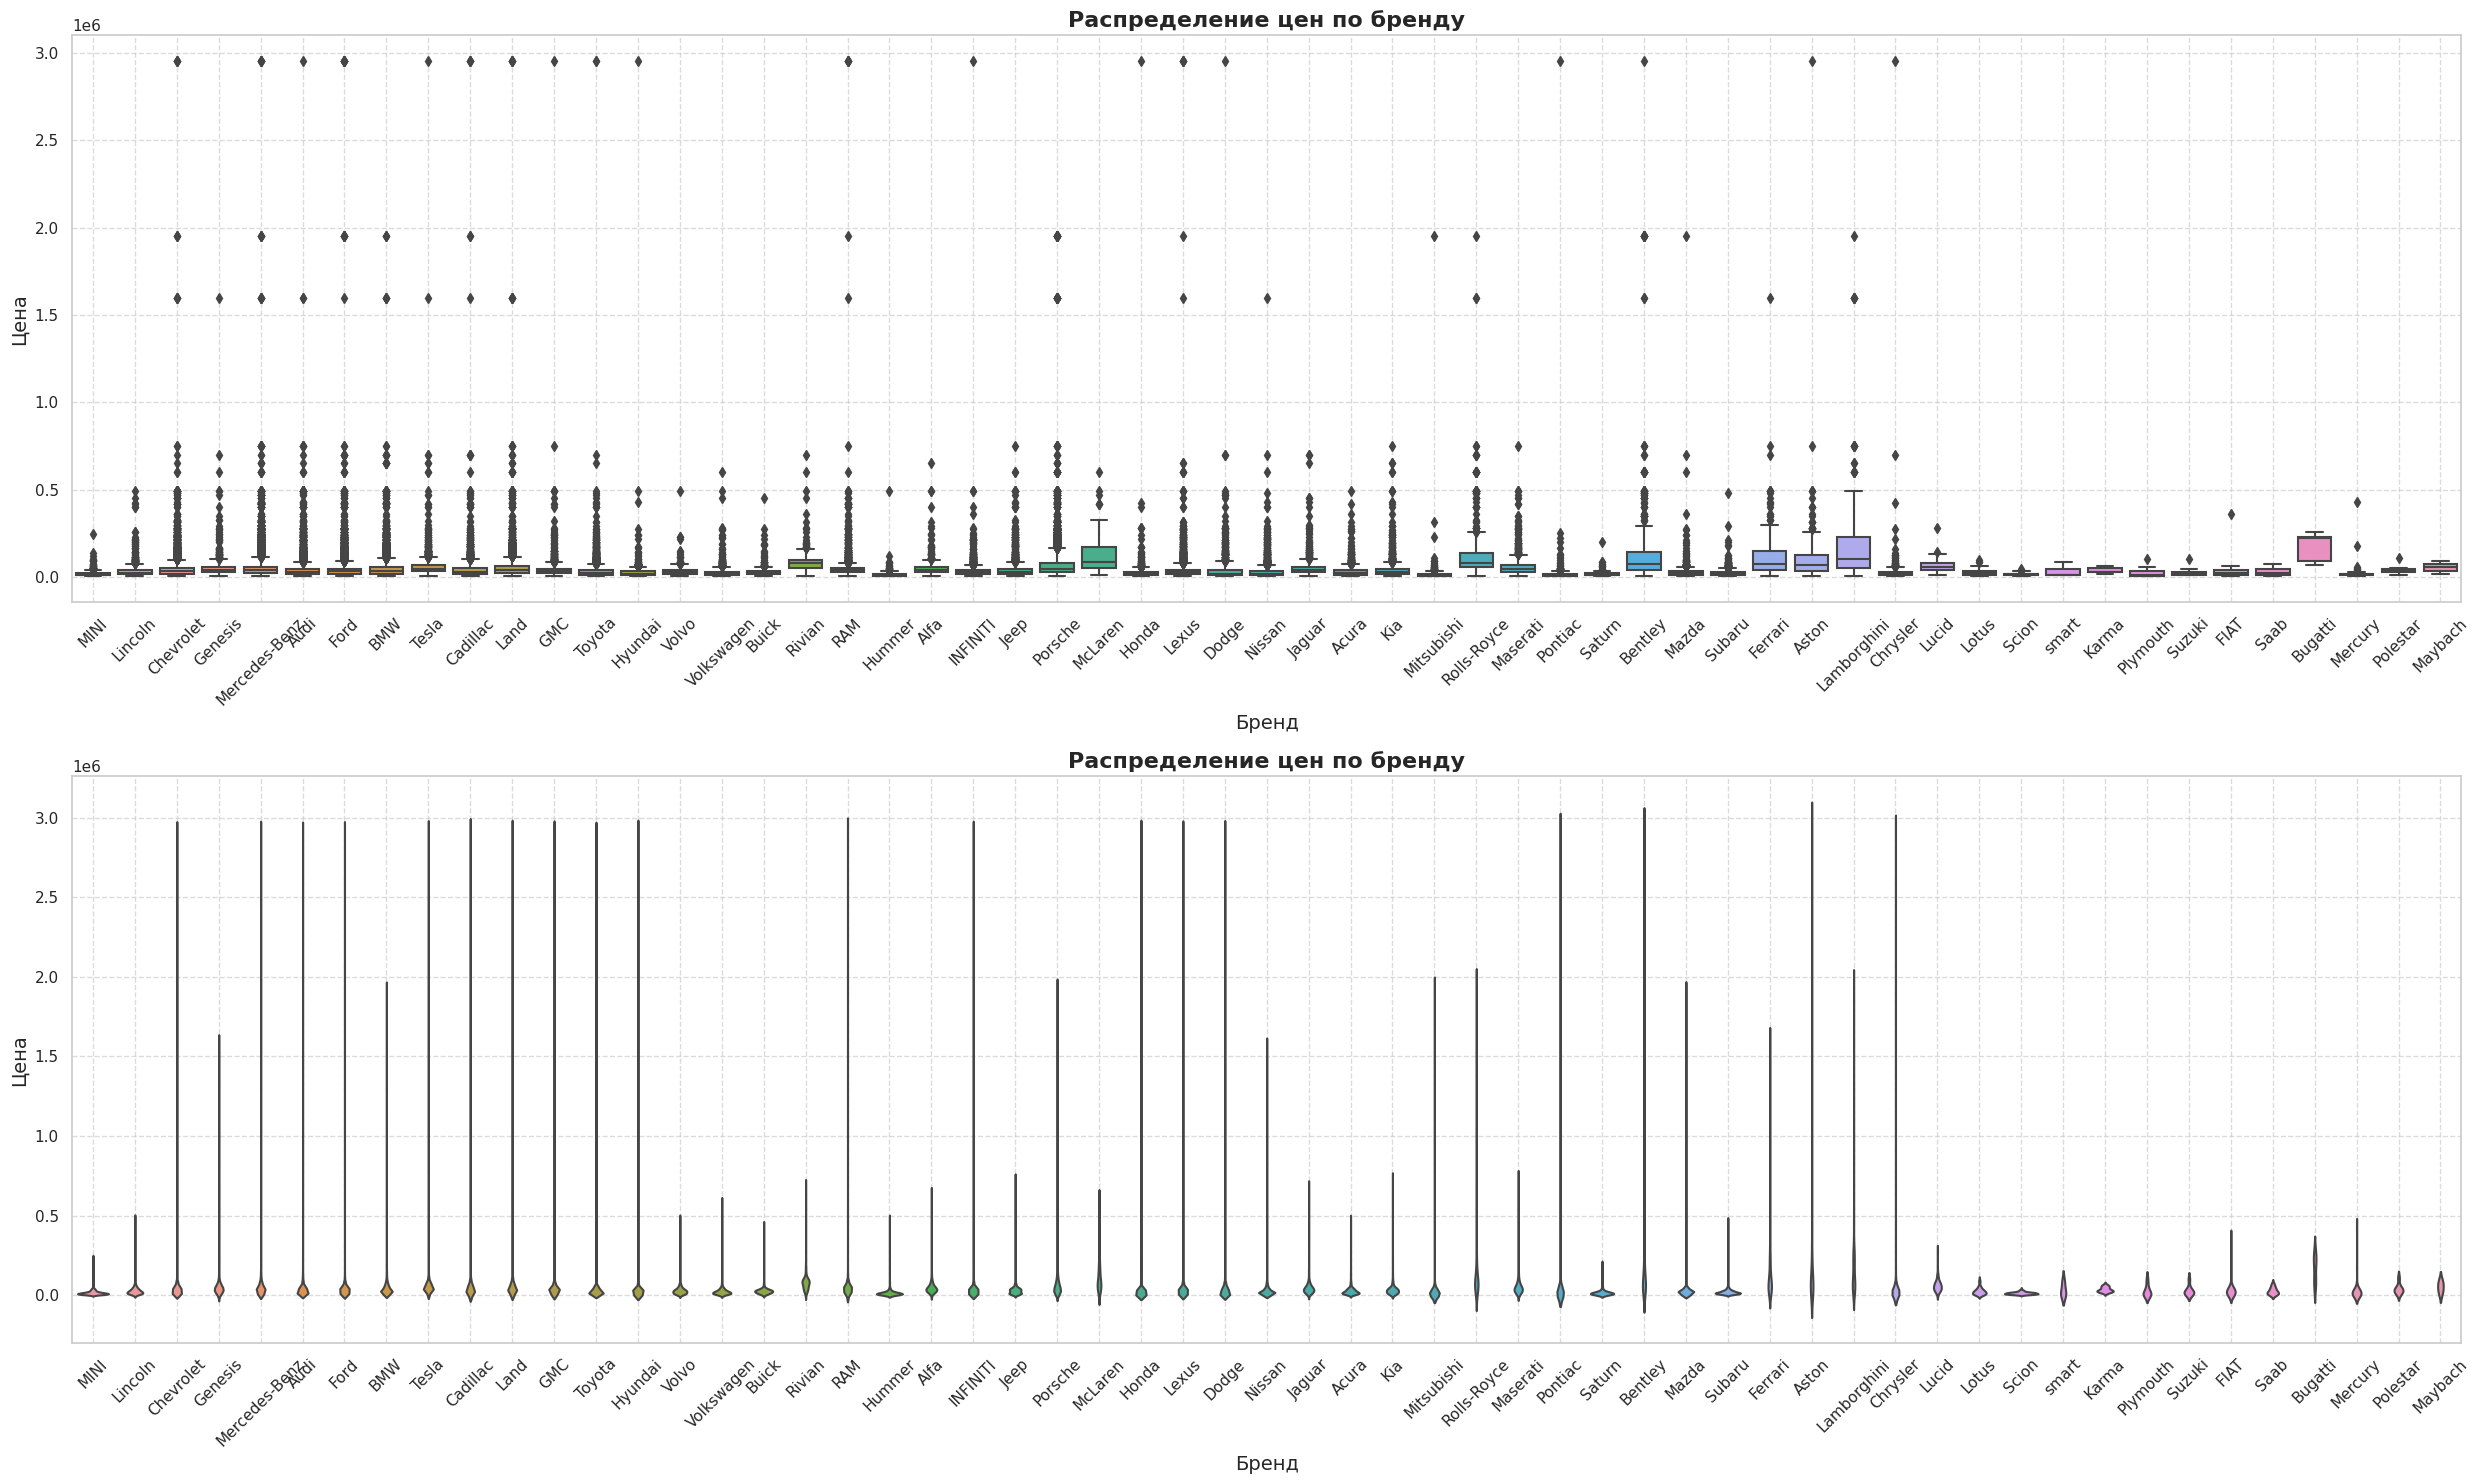

In [16]:
# Set up the figure and axes
fig, ax = plt.subplots(2, 1, figsize=(25, 15)) 

# Set a general aesthetic style for the plots
sns.set(style="whitegrid")

# Box Plot for Price by Brand
sns.boxplot(x='brand', y='price', data=train, ax=ax[0])
ax[0].set_title('Распределение цен по бренду', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Бренд', fontsize=14)
ax[0].set_ylabel('Цена', fontsize=14)
ax[0].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[0].grid(True, linestyle='--', alpha=0.7)  # Orange grid lines
ax[0].tick_params(axis='x', rotation=45)

# Violin Plot for Price by Brand
sns.violinplot(x='brand', y='price', data=train, ax=ax[1], inner=None)
ax[1].set_title('Распределение цен по бренду', fontsize=16, fontweight='bold', )
ax[1].set_xlabel('Бренд', fontsize=14,)
ax[1].set_ylabel('Цена', fontsize=14,)
ax[1].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[1].grid(True, linestyle='--', alpha=0.7,)  # Orange grid lines
ax[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

## Distribution of Top 10 Exterior and Interior Colors 📊🚗

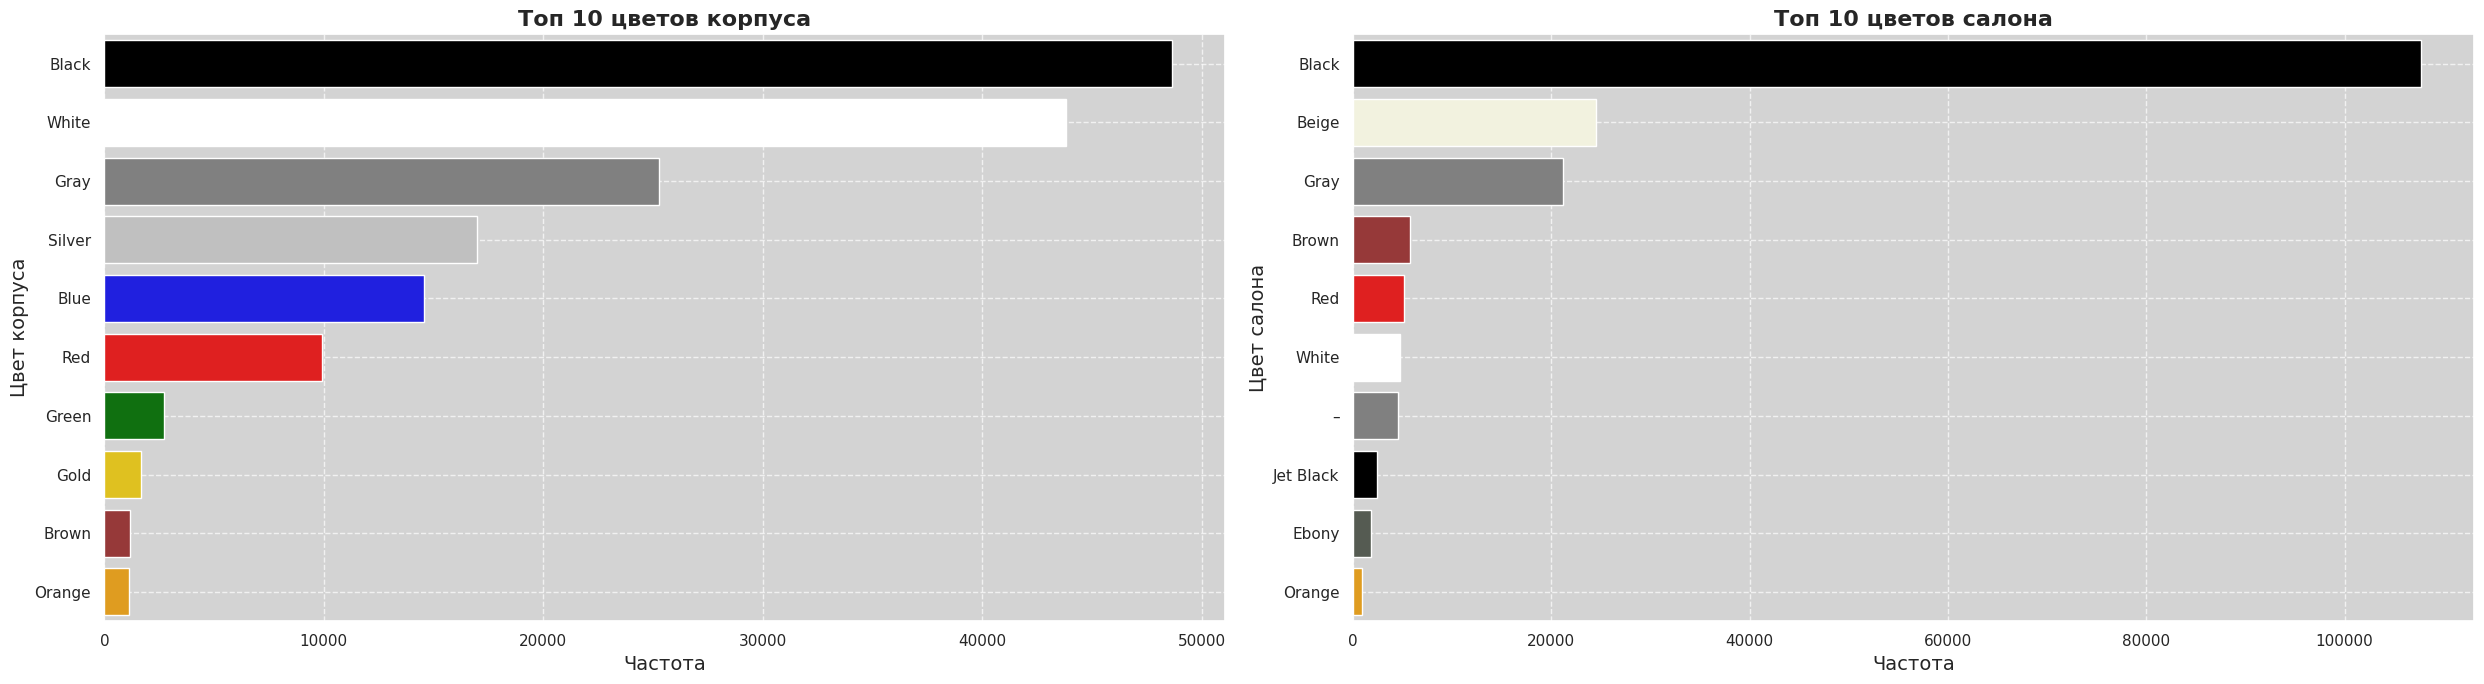

In [18]:
# Assuming 'train' is your DataFrame
top_n = 10  # Top N categories to visualize

# Define color mappings based on color names
color_map_ext = {
    "Black": "black",
    "White": "white",
    "Gray": "gray",
    "Silver": "silver",
    "Blue": "blue",
    "Red": "red",
    "Green": "green",
    "Gold": "gold",
    "Brown": "brown",
    "Orange": "orange"
}

color_map_int = {
    "Black": "black",
    "Beige": "#F5F5DC",  # Beige color
    "Gray": "gray",
    "Brown": "brown",
    "Red": "red",
    "White": "white",
    "-": "lightgray",  # Missing/unknown color
    "Jet Black": "black",
    "Ebony": "#555D50",  # Ebony-like color
    "Orange": "orange"
}

# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25, 7))  # 1 row, 2 columns for side-by-side plots

# Set a dark background
sns.set(style="darkgrid", rc={"axes.facecolor": "#D3D3D3"})  # Light gray background

# Bar Plot for Top 10 Exterior Colors
ext_color_counts = train['ext_col'].value_counts().head(top_n)
ext_colors = [color_map_ext.get(color, "gray") for color in ext_color_counts.index]
sns.barplot(x=ext_color_counts.values, y=ext_color_counts.index, palette=ext_colors, ax=ax[0])
ax[0].set_title('Топ 10 цветов корпуса', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Частота', fontsize=14)
# ax[0].patch.set_facecolor('#F5F5F5')
ax[0].set_ylabel('Цвет корпуса', fontsize=14)
ax[0].grid(True, linestyle='--', alpha=0.7)

# Bar Plot for Top 10 Interior Colors
int_color_counts = train['int_col'].value_counts().head(top_n)
int_colors = [color_map_int.get(color, "gray") for color in int_color_counts.index]
sns.barplot(x=int_color_counts.values, y=int_color_counts.index, palette=int_colors, ax=ax[1])
ax[1].set_title('Топ 10 цветов салона', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Частота', fontsize=14)
ax[1].set_ylabel('Цвет салона', fontsize=14)
# ax[1].patch.set_facecolor('#F5F5F5')
ax[1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


## Transmission Type Breakdown 🚗🔍

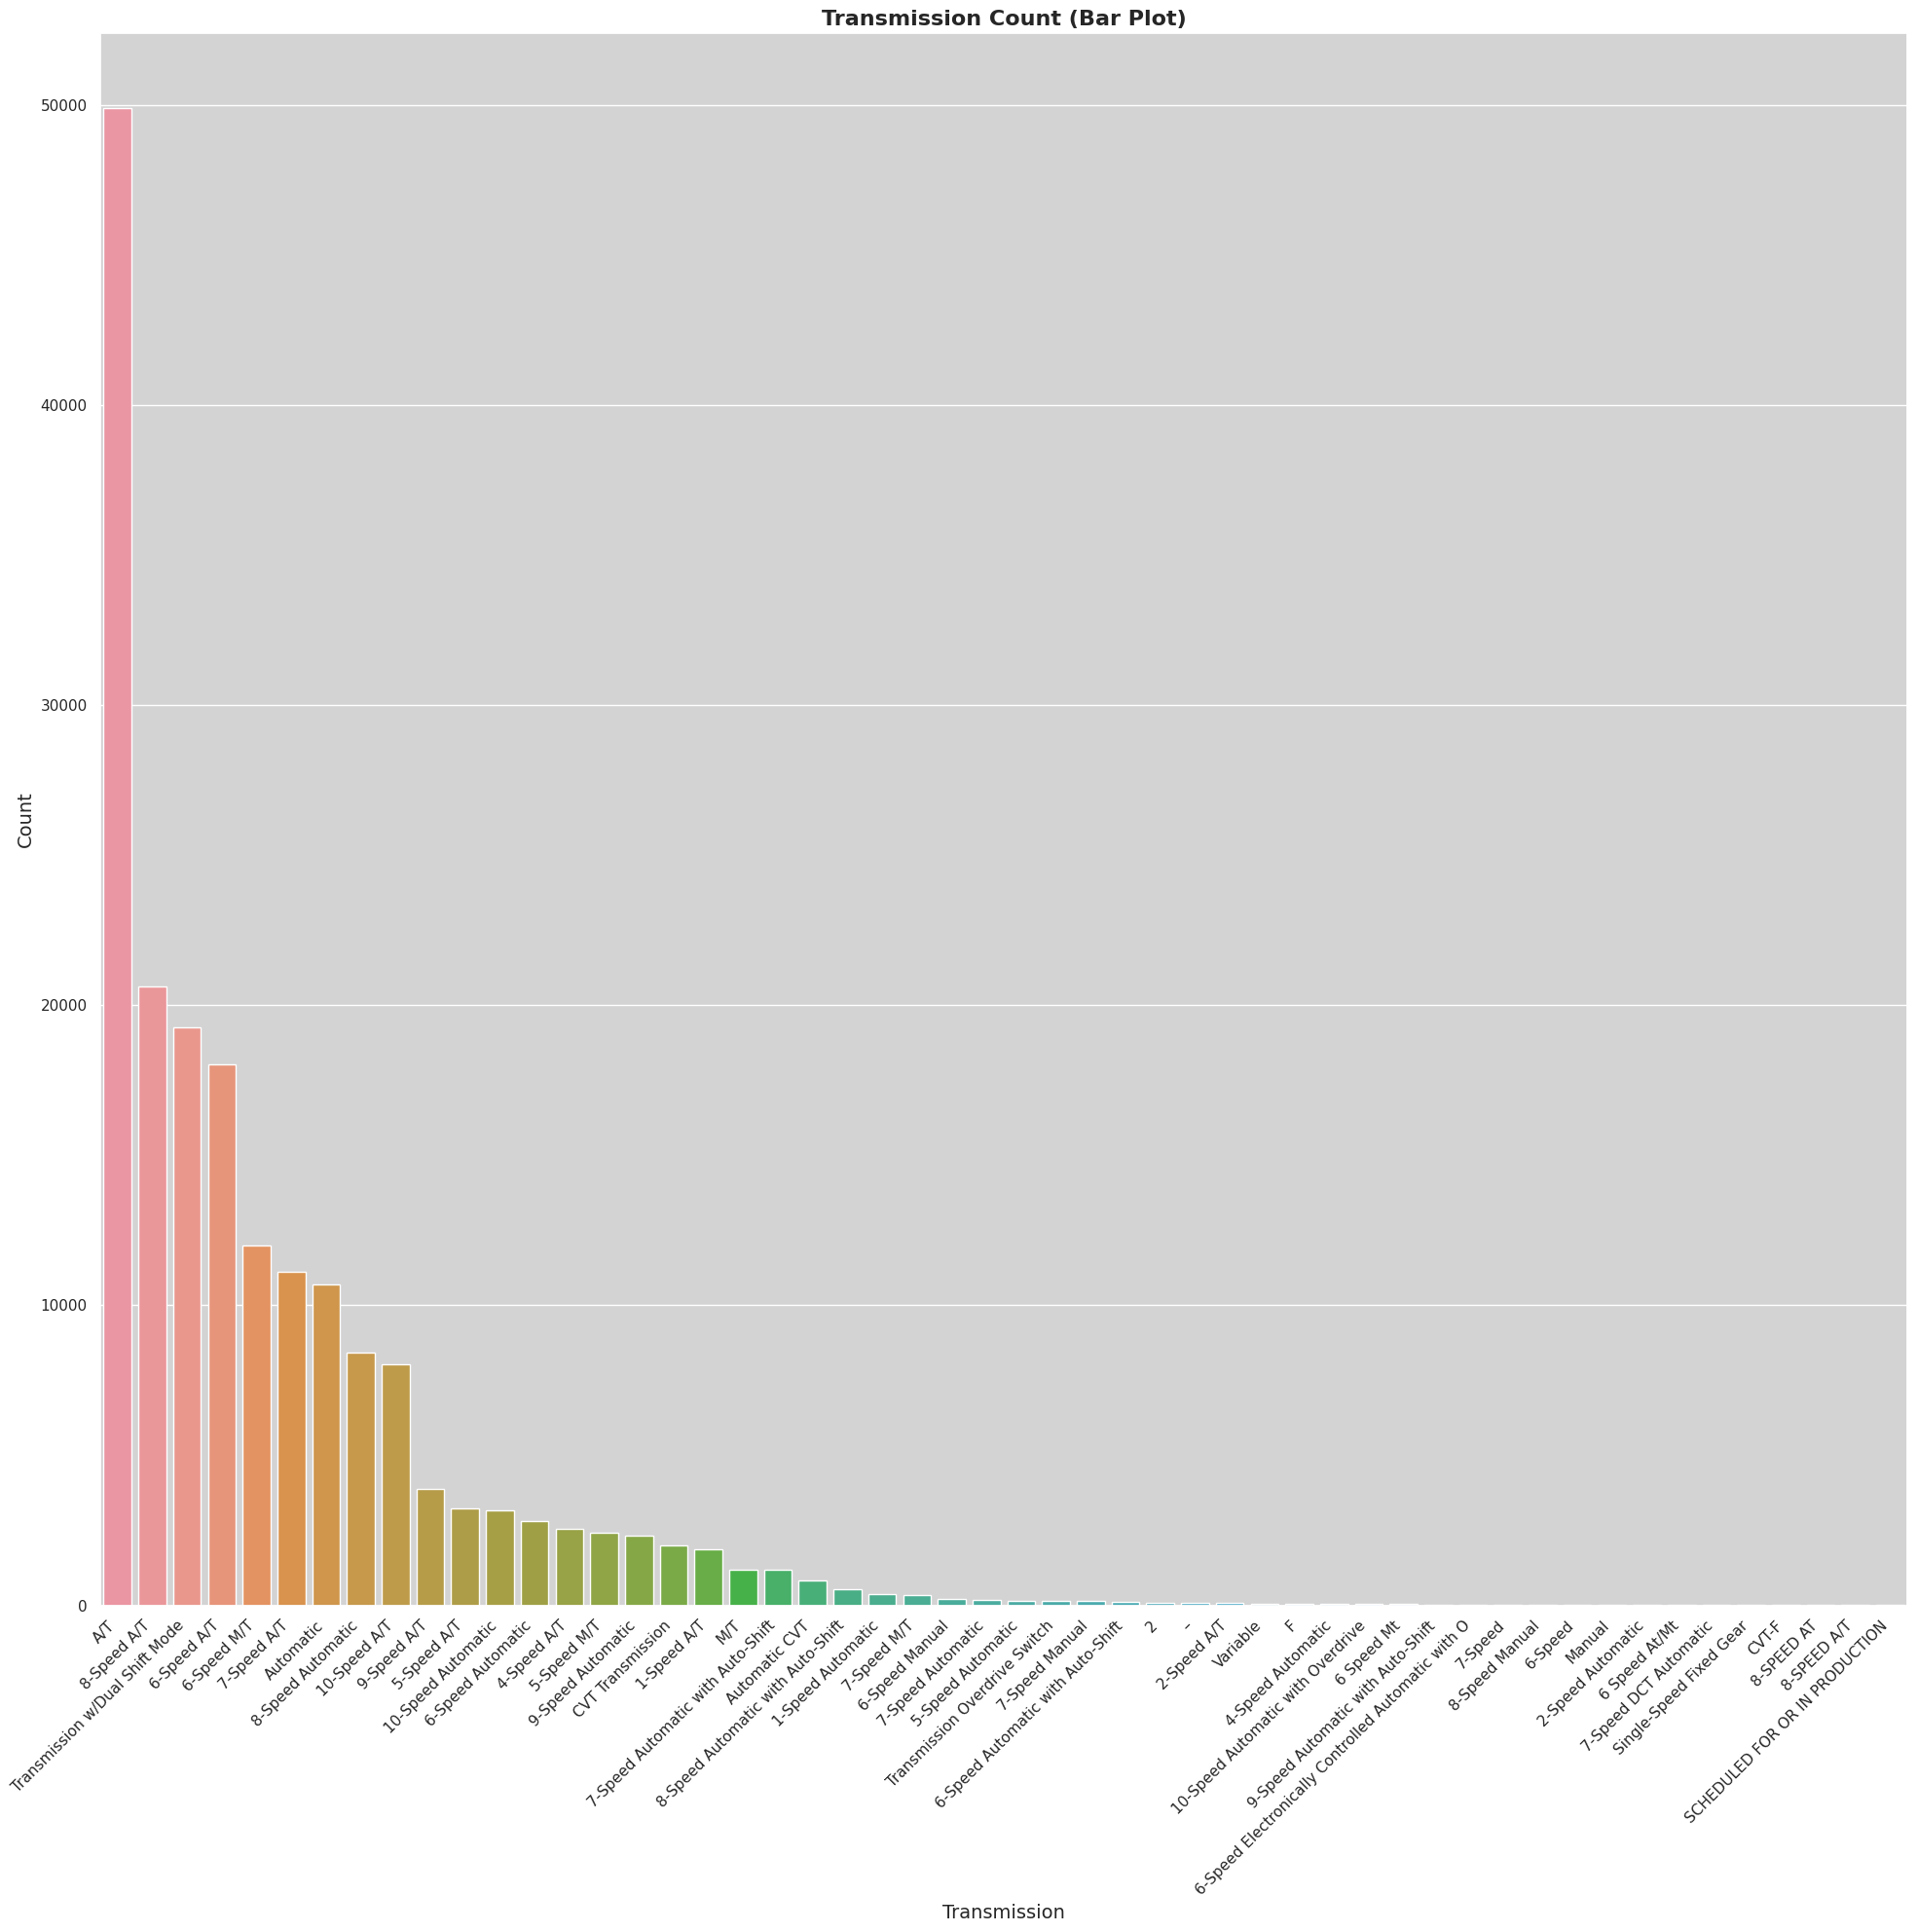

In [39]:
plt.figure(figsize=(20, 20))  # Increased size for better visibility

sns.countplot(x='transmission', data=train, order=train['transmission'].value_counts().index)

# Title and labels
plt.title('Transmission Count (Bar Plot)', fontsize=16, fontweight='bold')
plt.xlabel('Transmission', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Adjust x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability

# Adjust layout to avoid clipping of labels
plt.tight_layout()

# Show plot
plt.show()

## Identifying Missing Values in the Dataset 🔍

In [40]:
train.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

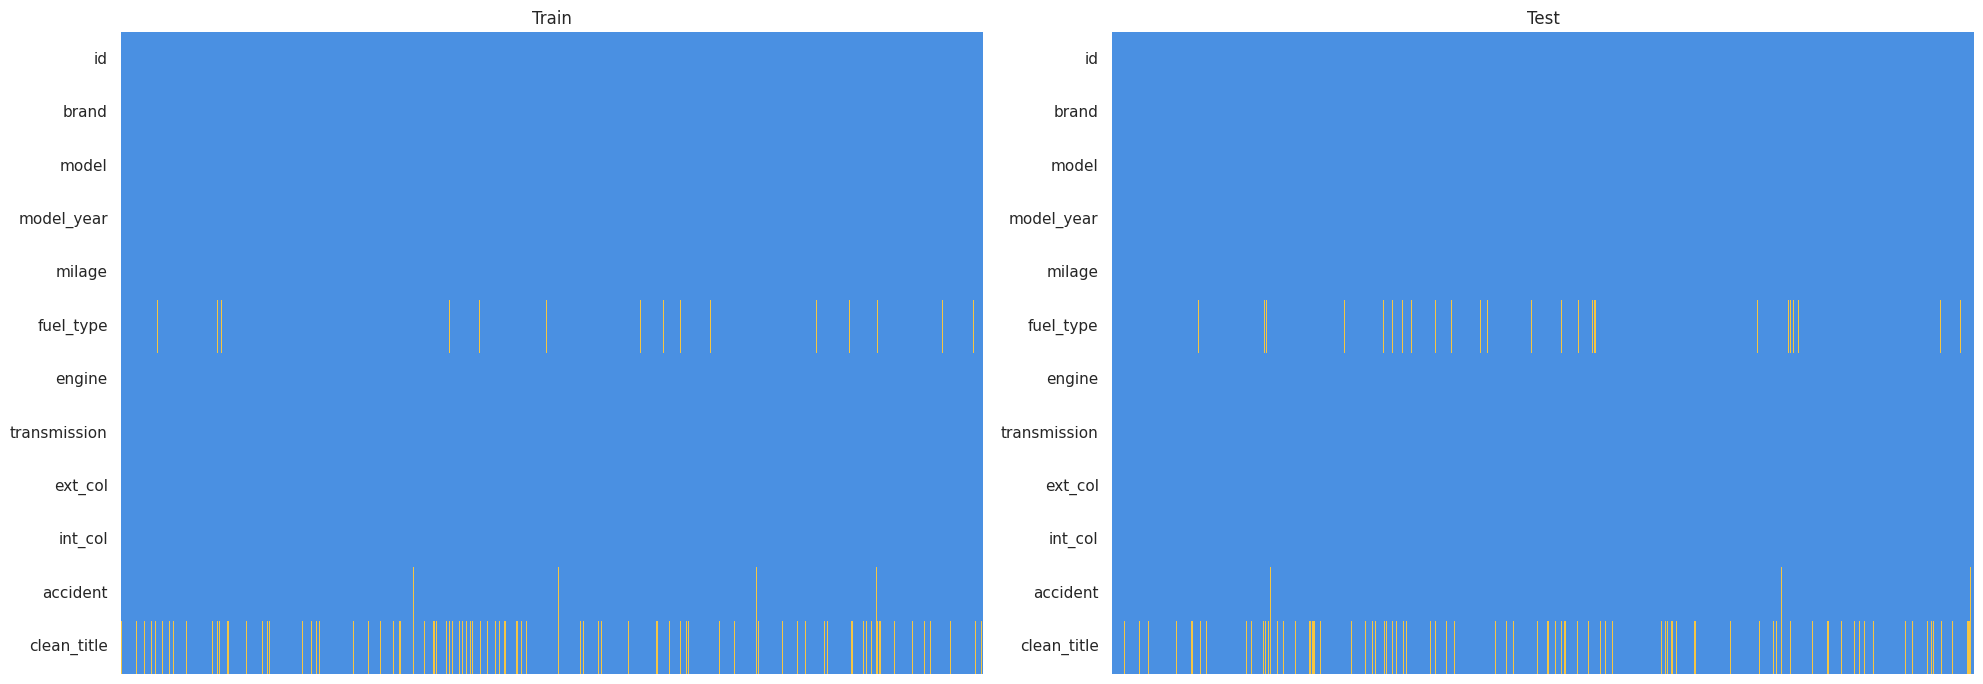

In [41]:
# Custom color palette
custom_palette = ['#4A90E2', '#F5C542']
# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_palette, N=256)

# Sample data for null values heatmap
train_null_values = train.sample(100_000).drop(columns=['price']).isnull().T
test_null_values = test.sample(100_000).isnull().T

# Plotting the heatmaps
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

sns.heatmap(train_null_values, cbar=False, cmap=cmap, ax=axes[0])
axes[0].set_title('Train')
axes[0].set_xticks([]) 
axes[0].set_xlabel('')

sns.heatmap(test_null_values, cbar=False, cmap=cmap, ax=axes[1])
axes[1].set_title('Test')
axes[1].set_xticks([]) 
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

## Feature Engineering 🛠️ 

In [43]:
def extract_age_features(df):
    current_year = 2024

    df['Vehicle_Age'] = current_year - df['model_year']
    df['Mileage_per_Year'] = df['milage'] / df['Vehicle_Age']   
    
    return df

In [44]:
def extract_engine_features(df):
    
    def extract_horsepower(engine):
        try:
            return float(engine.split('HP')[0])
        except:
            return None

    def extract_engine_size(engine):
        try:
            return float(engine.split(' ')[1].replace('L', ''))
        except:
            return None

    df['Horsepower'] = df['engine'].apply(extract_horsepower)
    df['Engine_Size'] = df['engine'].apply(extract_engine_size)
    df['Power_to_Weight_Ratio'] = df['Horsepower'] / df['Engine_Size']
    
    return df


In [45]:
def extract_other_features(df):
    
    luxury_brands =  ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land', 
                    'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini', 
                    'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    return df

In [46]:
train = extract_age_features(train)
test = extract_age_features(test)

train = extract_engine_features(train)
test = extract_engine_features(test)

train = extract_other_features(train)
test = extract_other_features(test)

In [47]:
train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Vehicle_Age,Mileage_per_Year,Horsepower,Engine_Size,Power_to_Weight_Ratio,Is_Luxury_Brand
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,17,12529.411765,172.0,1.6,107.500000,0
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,6511.363636,252.0,3.9,64.615385,0
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,22,6215.045455,320.0,5.3,60.377358,0
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,7,2785.714286,420.0,5.0,84.000000,0
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,3,2462.666667,208.0,2.0,104.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500,7,7000.000000,420.0,6.2,67.741935,0
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000,6,4766.666667,385.0,3.0,128.333333,1
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900,3,4550.000000,469.0,4.0,117.250000,1
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900,2,6947.500000,NaN,NaN,NaN,1


In [48]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

In [49]:
cat_features = test.select_dtypes('object').columns
# Reference: https://www.kaggle.com/code/ambrosm/pss4e8-eda-which-makes-sense
for feature in cat_features:          
    categories = sorted(list(set(train[feature].dropna())))
    dtype = pd.CategoricalDtype(categories=categories, ordered=False)
    
    train.loc[~train[feature].isin(categories), feature] = np.nan
    test.loc[~test[feature].isin(categories), feature] = np.nan
    
    train[feature] = train[feature].astype(dtype)
    test[feature] = test[feature].astype(dtype)

In [57]:
def remove_nan_inf(data):
    if isinstance(data, pd.DataFrame):
        # Удаляем строки, содержащие NaN, inf или -inf
        data = data[~data.isin([np.nan, np.inf, -np.inf]).any(axis=1)].reset_index(drop=True)
    elif isinstance(data, np.ndarray):
        # Если это массив numpy
        mask = ~np.isnan(data).any(axis=1) & ~np.isinf(data).any(axis=1)
        data = data[mask]
    return data

In [19]:
train = remove_nan_inf(train)

X = train.drop(columns=["id", "price"])
y = train["price"]

# Определение базовых моделей
base_models = [
    ('xgb', XGBRegressor(n_estimators=100, random_state=42, enable_categorical=True)),
    ('lgbm', LGBMRegressor(n_estimators=100, random_state=42)),
    ('catboost', CatBoostRegressor(n_estimators=100, random_state=42, cat_features=cat_cols, verbose=0))
]

# Метамодель
meta_model = Ridge(alpha=1.0)

# Создание StackingRegressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Обучение стэкинг-модели
stacking_regressor.fit(X_train, y_train)

# Предсказания и оценка
y_pred = stacking_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (Stacking): {rmse:.4f}")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3494
[LightGBM] [Info] Number of data points in the train set: 118846, number of used features: 16
[LightGBM] [Info] Start training from score 38579.252587
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004379 seconds.
You can set `force_row_

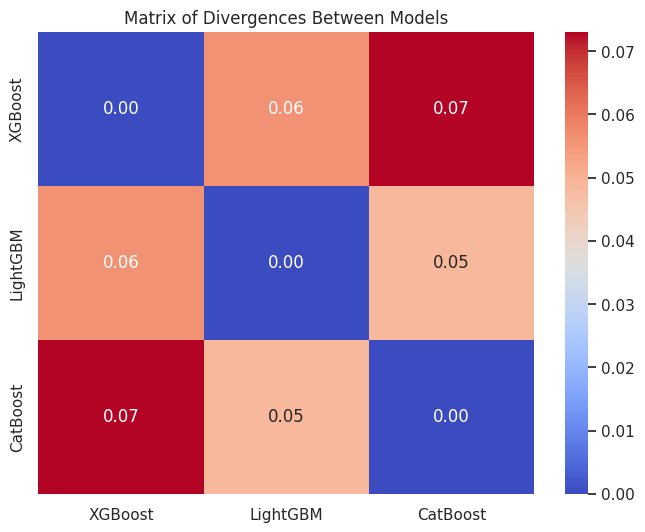

In [21]:
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Предсказания каждой модели
predictions = {
    'XGBoost': models['XGBoost'].predict(X_test),
    'LightGBM': models['LightGBM'].predict(X_test),
    'CatBoost': models['CatBoost'].predict(X_test)
}

# Матрица корреляций предсказаний
divergence_matrix = np.zeros((len(predictions), len(predictions)))
model_names = list(predictions.keys())

for i, model_1 in enumerate(model_names):
    for j, model_2 in enumerate(model_names):
        # Используем корреляцию Спирмена для измерения связи между предсказаниями
        corr, _ = spearmanr(predictions[model_1], predictions[model_2])
        divergence_matrix[i, j] = 1 - corr  # 1 - корреляция для измерения дивергенции

# Построение тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(divergence_matrix, annot=True, xticklabels=model_names, yticklabels=model_names, cmap='coolwarm', fmt=".2f")
plt.title("Matrix of Divergences Between Models")
plt.show()

In [75]:
# Обучение и оценка моделей по отдельности
models = {
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, enable_categorical=True),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(n_estimators=100, random_state=42, cat_features=cat_cols, verbose=0)
}

for name, model in models.items():
    # Обучение модели
    model.fit(X_train, y_train)
    # Предсказания
    y_pred = model.predict(X_test)
    # Расчёт RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE for {name}: {rmse:.4f}")

# Оценка для стэкинг-модели
y_pred_stacking = stacking_regressor.predict(X_test)
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
print(f"RMSE for Stacking Ensemble: {rmse_stacking:.4f}")

RMSE for XGBoost: 66988.3053
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3494
[LightGBM] [Info] Number of data points in the train set: 118846, number of used features: 16
[LightGBM] [Info] Start training from score 38579.252587
RMSE for LightGBM: 62516.8375
RMSE for CatBoost: 63405.5987
RMSE for Stacking Ensemble: 62537.5702
